In [1]:
from __future__ import absolute_import, division, print_function
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
dir="../input/cell-images-for-detecting-malaria/cell_images/cell_images"

# Dataset Loading

In [2]:
from sklearn.datasets import load_files
import numpy as np

def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np.array(data['target'])
    target_labels = np.array(data['target_names'])
    return files,targets,target_labels
    
_,_, labels_name = load_dataset(dir)
print('Loading complete!')




Loading complete!


In [3]:
infected = os.listdir('../input/cell-images-for-detecting-malaria/cell_images/cell_images/Parasitized/') 
uninfected = os.listdir('../input/cell-images-for-detecting-malaria/cell_images/cell_images/Uninfected/')

In [4]:
data = []
labels = []

for i in infected:
    try:
        image = cv2.imread(dir+"/Parasitized/"+i)
        image_array = Image.fromarray(image , 'RGB')
        resize_img = image_array.resize((50 , 50))
        data.append(np.array(resize_img))
        labels.append(1)
        
    except AttributeError:
        print('')
    
for u in uninfected:
    try:
        
        image = cv2.imread(dir+"/Uninfected/"+u)
        image_array = Image.fromarray(image , 'RGB')
        resize_img = image_array.resize((50 , 50))
        data.append(np.array(resize_img))
        labels.append(0)
    except AttributeError:
        print('')

In [5]:
images = np.array(data)
labels = np.array(labels)

np.save('Cells' , images)
np.save('Labels' , labels)

In [6]:
print('Cells : {} | labels : {}'.format(images.shape , labels.shape))

Cells : (27558, 50, 50, 3) | labels : (27558,)


## Visualization a potion of sample training dataset

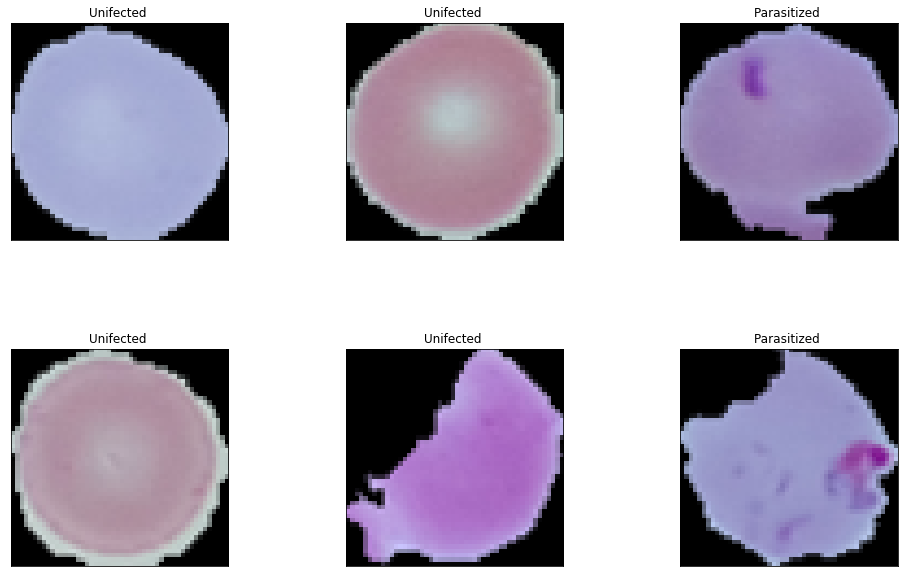

In [7]:
plt.figure(1 , figsize = (16 , 10))
n = 0 
for i in range(6):
    n += 1 
    r = np.random.randint(0 , images.shape[0] , 1)
    plt.subplot(2 , 3, n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(images[r[0]])
    plt.title('{} '.format( 'Parasitized' if labels[r[0]] == 1 else  'Unifected' ,
                               labels[r[0]]) )
    plt.xticks([]) , plt.yticks([])
    
plt.show()

In [8]:
images = images.astype(np.float32)
labels = labels.astype(np.int32)
images = images/255

# Spliting dataset into train, test , validation dataset

In [9]:
from sklearn.model_selection import train_test_split

train_x , x , train_y , y = train_test_split(images , labels , 
                                            test_size = 0.2 ,
                                            random_state = 111)

eval_x , test_x , eval_y , test_y = train_test_split(x , y , 
                                                    test_size = 0.5 , 
                                                    random_state = 111)

In [10]:
print('train data shape {} ,eval data shape {} , test data shape {}'.format(train_x.shape,
                                                                           eval_x.shape ,
                                                                           test_x.shape))

train data shape (22046, 50, 50, 3) ,eval data shape (2756, 50, 50, 3) , test data shape (2756, 50, 50, 3)


In [11]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(50, 50, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 128)         0

In [12]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
print('Compiled!')

Compiled!


In [13]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.987 ):
            print("\nReached 98.7% accuracy so cancelling training!")
            self.model.stop_training = True 

In [14]:
callbacks=myCallback()
history = model.fit(train_x,train_y,
        batch_size = 80,
        epochs=50,
        validation_data=(eval_x, eval_y),
        callbacks = callbacks,
        verbose=1, shuffle=True)

Epoch 1/50
276/276 [==============================] - 2s 8ms/step - loss: 0.5391 - accuracy: 0.7048 - val_loss: 0.2183 - val_accuracy: 0.9209
Epoch 2/50
276/276 [==============================] - 2s 7ms/step - loss: 0.1905 - accuracy: 0.9356 - val_loss: 0.2186 - val_accuracy: 0.9260
Epoch 3/50
276/276 [==============================] - 2s 7ms/step - loss: 0.1582 - accuracy: 0.9488 - val_loss: 0.1736 - val_accuracy: 0.9434
Epoch 4/50
276/276 [==============================] - 2s 7ms/step - loss: 0.1452 - accuracy: 0.9522 - val_loss: 0.1518 - val_accuracy: 0.9554
Epoch 5/50
276/276 [==============================] - 2s 7ms/step - loss: 0.1396 - accuracy: 0.9545 - val_loss: 0.1447 - val_accuracy: 0.9528
Epoch 6/50
276/276 [==============================] - 2s 7ms/step - loss: 0.1337 - accuracy: 0.9558 - val_loss: 0.1638 - val_accuracy: 0.9430
Epoch 7/50
276/276 [==============================] - 2s 7ms/step - loss: 0.1301 - accuracy: 0.9570 - val_loss: 0.1456 - val_accuracy: 0.9583
Epoch 

In [15]:
# evaluate and print test accuracy
score = model.evaluate(test_x, test_y, verbose=0)
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.9579100012779236


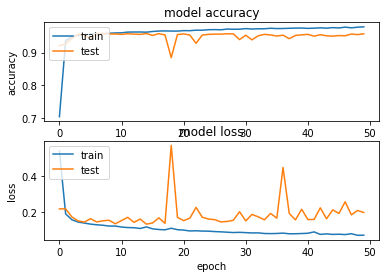

In [16]:
import matplotlib.pyplot as plt 
plt.figure(1)  
# summarize history for accuracy  
plt.subplot(211)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
   
 # summarize history for loss  
   
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()

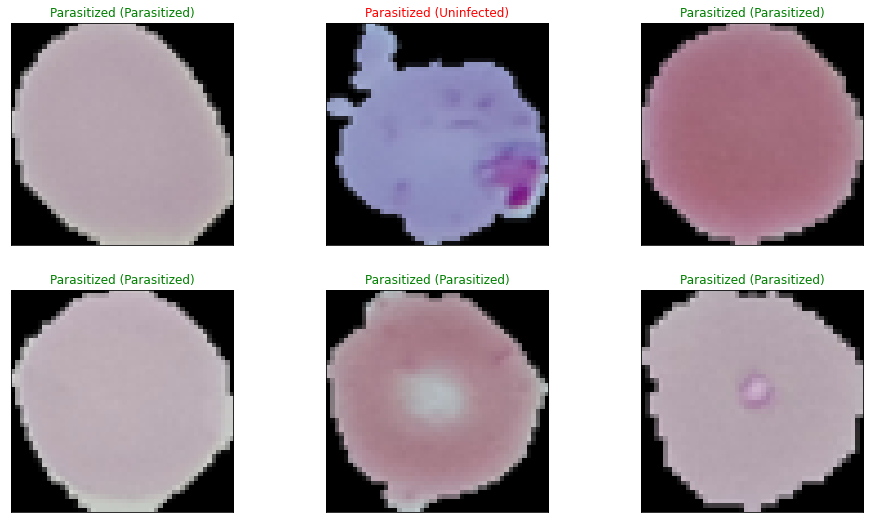

In [17]:

y_pred = model.predict(test_x)

# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(16, 9))
for i, idx in enumerate(np.random.choice(test_x.shape[0], size=6, replace=False)):
    ax = fig.add_subplot(2, 3, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(test_x[idx]))
    pred_idx = np.argmax(y_pred[idx])
    true_idx = test_y[idx]
    ax.set_title("{} ({})".format(labels_name[pred_idx], labels_name[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))